## Concept

* uses data from the same input variable in a lagged format
* Limited forecast power like simple moving averages

* $ y_t = c + \phi_1 y_{t-1} + .. + \phi_p y_{t-p} + \epsilon_t $

* Variables:
    * $\epsilon$ - irreducible error (white noise)
    * $\phi$ - coefficient
    * p - order
    
* Higher order of p gives better forecasting results, but only to certain point

## Prepare Data

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AR
import matplotlib.pyplot as plt

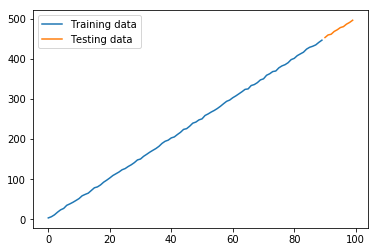

In [2]:
np.random.seed(123)
x = np.arange(0, 500, 5)
y = [i + np.random.random()*5 for i in x]
df = pd.DataFrame(data = {'x': x, 'y': y})

df_train = df[:-10]
df_test = df[-10:]

plt.plot(df_train['y'], label='Training data')
plt.plot(df_test['y'], label='Testing data')
plt.legend();

## Approach 1 
1. Build library based model
2. Find Optimal order
3. Fit optimal order and metric

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


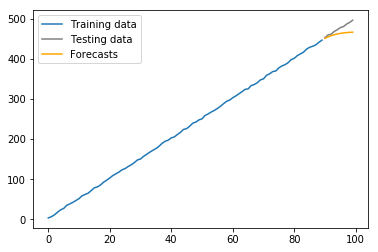

In [3]:
# fit model
model = AR(df_train['y']).fit(maxlag = 2, method = 'mle')
df_test['forecast'] = model.predict(start=len(df_train), end=len(df_train) + len(df_test) - 1,
        dynamic=False)

plt.plot(df_train['y'], label='Training data')
plt.plot(df_test['y'], color='gray', label='Testing data')
plt.plot(df_test['forecast'], color='orange', label='Forecasts')
plt.legend()

## Finding Optimal lag

In [4]:
# Max lag order
max_p = 20
# To store RMSE
errors = {}

for p in range(1, max_p + 1):
    # Train and predict
    model = AR(df_train['y']).fit(maxlag=p, dynamic=False)
    preds = model.predict(
        start=len(df_train),
        end=len(df_train) + len(df_test) - 1,
        dynamic=False
    )
    # Calculate and store RMSE
    error = mean_squared_error(df_test['y'], preds)
    errors[f'AR({p})'] = np.round(error, 2)
errors


{'AR(1)': 2.05,
 'AR(2)': 2.5,
 'AR(3)': 3.72,
 'AR(4)': 3.87,
 'AR(5)': 3.05,
 'AR(6)': 2.62,
 'AR(7)': 2.21,
 'AR(8)': 2.09,
 'AR(9)': 1.45,
 'AR(10)': 1.49,
 'AR(11)': 1.52,
 'AR(12)': 1.47,
 'AR(13)': 2.02,
 'AR(14)': 2.06,
 'AR(15)': 2.19,
 'AR(16)': 2.2,
 'AR(17)': 2.2,
 'AR(18)': 2.01,
 'AR(19)': 1.95,
 'AR(20)': 1.83}

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Program Files\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


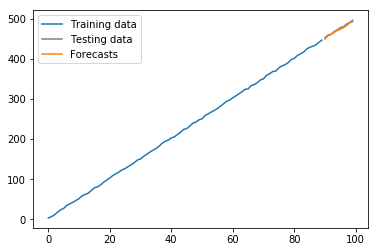

In [5]:
# fit best model
model = AR(df_train['y']).fit(maxlag = 11, method = 'mle')
df_test['forecast'] = model.predict(start=len(df_train), end=len(df_train) + len(df_test) - 1,
        dynamic=False)

plt.plot(df_train['y'], label='Training data')
plt.plot(df_test['y'], color='gray', label='Testing data')
plt.plot(df_test['forecast'], label='Forecasts')
plt.legend()

## Summary

* AR works for simple datasets
* Despite lag 12 found to be optimal, but we need to use it with AIC
* AR models with Airline passengers wont work regardless of order, but if we make stationary it can still wont be better than exp smoothing

## Approach 2
1. Build AR model from scratch
2. Compare against library based model

In [6]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

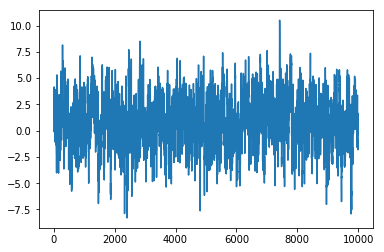

In [7]:
df = pd.read_excel(r'../data/ts_data.xlsx')
plt.plot(df.Value)

In [8]:
# Confirm stationarity

X = df["Value"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -22.184930
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Reject Ho - Time Series is Stationary


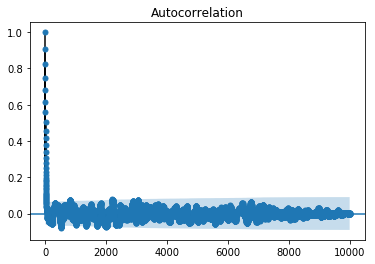

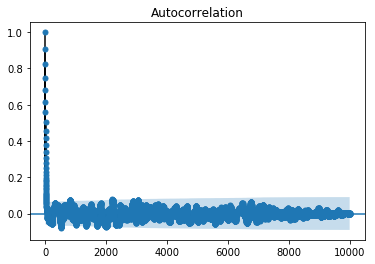

In [9]:
plot_acf(X)

intercept : 0.06822494315175742, coeff : 0.9054874230983847


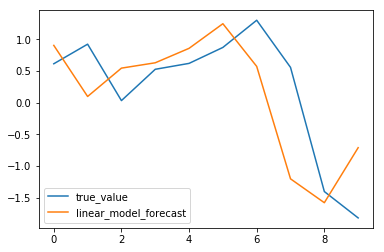

In [10]:
# Build Linear Regression

df['y'] = df['Value'].shift(1)
df = df.dropna(axis = 0)

train_size = int(len(df)*0.80)
xtrain, ytrain = df['Value'][0:train_size].values, df['y'][0:train_size].values
xtest, ytest = df['Value'][train_size:].values, df['y'][train_size:].values

xtrain = xtrain.reshape(-1, 1)
xtest = xtest.reshape(-1, 1)

lr_model = LinearRegression()
lr_model.fit(xtrain, ytrain)
print(f"intercept : {lr_model.intercept_}, coeff : {lr_model.coef_[0]}")
ytest_lr_forecast = lr_model.predict(xtest)

plt.plot(ytest[-10:], label = 'true_value')
plt.plot(ytest_lr_forecast[-10:], label = 'linear_model_forecast')
plt.legend()

In [13]:
# Build AR model
ar_model = ARIMA(ytrain, order = (1, 0, 0))
ar_model_fit = ar_model.fit()

print(f"lr intercept : {lr_model.intercept_}, lr coeff : {lr_model.coef_[0]}")
print(ar_model_fit.summary())

lr intercept : 0.06822494315175742, lr coeff : 0.9054874230983847
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 7999
Model:                     ARMA(1, 0)   Log Likelihood              -11364.740
Method:                       css-mle   S.D. of innovations              1.002
Date:                Mon, 13 Sep 2021   AIC                          22735.480
Time:                        21:53:32   BIC                          22756.441
Sample:                             0   HQIC                         22742.654
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7245      0.118      6.126      0.000       0.493       0.956
ar.L1.y        0.9054      0.005    190.940      0.000       0.89

C:\Program Files\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Program Files\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Program Files\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as a

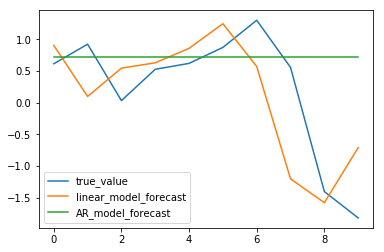

In [12]:
ytest_ar_forecast = ar_model_fit.forecast(len(ytest))

plt.plot(ytest[-10:], label = 'true_value')
plt.plot(ytest_lr_forecast[-10:], label = 'linear_model_forecast')
plt.plot(ytest_ar_forecast[0][-10:], label = 'AR_model_forecast')

plt.legend()